### Introdução

Para a realização deste trabalho, é fundamental justificar a escolha do modelo específico utilizado na tarefa de POS Tagging. Inicialmente, foi identificado que a melhor abordagem envolveria a utilização do modelo BERT, devido ao seu alto desempenho em tarefas de classificação. A partir disso, duas possibilidades foram consideradas: utilizar o modelo sem fine-tuning e realizar o treinamento manualmente ou optar por um modelo já ajustado previamente com o corpus Mac-Morpho.

Após análise das alternativas, concluiu-se que a opção mais vantajosa seria o uso do modelo já ajustado (fine-tuned), em razão dos seguintes fatores: em primeiro lugar, evitaria a necessidade de treinar o modelo do zero, um processo que demandaria considerável tempo e recursos computacionais, especialmente no que se refere ao uso de GPU, cujo custo pode ser elevado dependendo da necessidade de processamento.

Além disso, o modelo já ajustado foi especificamente treinado para a tarefa de POS Tagging em português utilizando o corpus Mac-Morpho, garantindo, assim, um alto nível de precisão desde o início e estabelecendo uma base sólida para o desenvolvimento do trabalho. Por fim, a escolha do modelo pré-ajustado também se justifica pela redução da complexidade no treinamento e na necessidade de ajustes adicionais, tornando o processo mais simplificado e ao mesmo tempo acessivel para quem for utilizar.

In [1]:
import pandas as pd
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

c:\Users\igorb\Desktop\NLP\TP2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carregar e Processar os Dados

In [2]:
def load_data(file_path):
    sentences = []
    tags = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            words = []
            labels = []
            tokens = line.strip().split()
            for token in tokens:
                if '_' in token:
                    word, tag = token.rsplit('_', 1)
                    words.append(word)
                    labels.append(tag)
                else:
                    words.append(token)
                    labels.append('O')
            sentences.append(words)
            tags.append(labels)
    return sentences, tags

### Carregamento dos Dados

In [3]:
train_sentences, train_tags = load_data('macmorpho-train.txt')
dev_sentences, dev_tags = load_data('macmorpho-dev.txt')
test_sentences, test_tags = load_data('macmorpho-test.txt')

print(f"Número de Sentenças - Treinamento: {len(train_sentences)}, Validação: {
      len(dev_sentences)}, Teste: {len(test_sentences)}")

Número de Sentenças - Treinamento: 37948, Validação: 1997, Teste: 9987


### Carregando Tokenizer e Modelo Pré-treinado

In [4]:
model_name = "lisaterumi/postagger-portuguese"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Dispositivo Utilizado: {device}")

Dispositivo Utilizado: cuda


### Mapeamento de labels do modelo

In [5]:
id2label = model.config.id2label
label2id = model.config.label2id
num_labels = len(id2label)
print(f"Número de Classes: {num_labels}")
print("\nLabels do Modelo:")
for id, label in id2label.items():
    print(f"{id}: {label}")

Número de Classes: 27

Labels do Modelo:
0: NUM
1: KS
2: PREP+PROADJ
3: ADV-KS
4: NPROP
5: PDEN
6: PROADJ
7: PCP
8: KC
9: PU
10: PREP
11: ADV
12: PRO-KS
13: ART
14: N
15: PROPESS
16: PREP+PROPESS
17: CUR
18: ADJ
19: IN
20: PREP+ART
21: PROSUB
22: PREP+PRO-KS
23: PREP+PROSUB
24: V
25: PREP+ADV
26: <pad>


### Verificar se as Labels do Conjunto de Dados Estão no Modelo

In [6]:
all_data_labels = set(
    [tag for doc in train_tags + dev_tags + test_tags for tag in doc])
model_labels = set(id2label.values())
missing_labels = all_data_labels - model_labels

if missing_labels:
    print("\nLabels ausentes no modelo:")
    print(missing_labels)
else:
    print("\nTodas as labels do conjunto de dados estão presentes no modelo.")


Todas as labels do conjunto de dados estão presentes no modelo.


### Predizendo as Tags de uma Sentença

In [7]:
def predict_tags(sentence, tokenizer, model, id2label, device):
    encoding = tokenizer(sentence, is_split_into_words=True,
                         return_tensors="pt", truncation=True, padding=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    word_ids = encoding.word_ids(batch_index=0)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=2)

    predicted_labels = []
    previous_word_idx = None
    for idx, word_idx in enumerate(word_ids):
        if word_idx is None:
            continue
        if word_idx != previous_word_idx:
            label = id2label[predictions[0][idx].item()]
            predicted_labels.append(label)
            previous_word_idx = word_idx
    return predicted_labels

### Avaliando Modelo

In [8]:
def evaluate_model(sentences, true_tags, tokenizer, model, id2label, device):
    all_true = []
    all_pred = []

    for sentence, tags in zip(sentences, true_tags):
        preds = predict_tags(sentence, tokenizer, model, id2label, device)
        all_true.extend(tags)
        all_pred.extend(preds)

    filtered_true = []
    filtered_pred = []
    for true, pred in zip(all_true, all_pred):
        if pred != "<pad>":
            filtered_true.append(true)
            filtered_pred.append(pred)

    report = classification_report(
        filtered_true, filtered_pred, zero_division=0, digits=4)
    print("Relatório de Classificação:\n")
    print(report)

    return filtered_true, filtered_pred

### Avaliando no Conjunto de Teste

In [9]:
true_tags_test, pred_tags_test = evaluate_model(
    test_sentences, test_tags, tokenizer, model, id2label, device)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Relatório de Classificação:

              precision    recall  f1-score   support

         ADJ     0.9611    0.9601    0.9606      8554
         ADV     0.9386    0.9041    0.9211      5446
      ADV-KS     0.8515    0.8478    0.8497       230
         ART     0.9890    0.9932    0.9911     12580
         CUR     0.0000    0.0000    0.0000       296
          IN     0.5462    0.7245    0.6228        98
          KC     0.9770    0.9843    0.9807      4531
          KS     0.9379    0.9157    0.9266      2538
           N     0.9703    0.9404    0.9551     36542
       NPROP     0.9756    0.9681    0.9718     15936
         NUM     0.6787    0.9551    0.7935      2541
         PCP     0.9698    0.9706    0.9702      3640
        PDEN     0.8239    0.9212    0.8699      1092
        PREP     0.9758    0.9882    0.9819     16778
    PREP+ADV     0.9643    0.8710    0.9153        31
    PREP+ART     0.9924    0.9916    0.9920     10219
 PREP+PRO-KS     0.9153    0.9310    0.9231        5

### Análise de Desempenho por Classe

In [10]:
def analyze_performance(true_tags, pred_tags, id2label):
    precision, recall, f1, support = precision_recall_fscore_support(
        true_tags, pred_tags, labels=list(id2label.values()), zero_division=0)
    labels = list(id2label.values())
    performance = pd.DataFrame({
        'Tag': labels,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    }).sort_values(by='F1-Score', ascending=False)

    print("Top 10 Classes com Maior F1-Score:")
    display(performance.head(10))

    print("\nTop 10 Classes com Menor F1-Score:")
    display(performance.tail(10))

analyze_performance(true_tags_test, pred_tags_test, id2label)

Top 10 Classes com Maior F1-Score:


,Tag,Precision,Recall,F1-Score,Support
2,PREP+PROADJ,0.996753,0.993528,0.995138,309
24,V,0.992911,0.994774,0.993842,19711
20,PREP+ART,0.992361,0.991584,0.991973,10219
13,ART,0.988997,0.993164,0.991076,12580
9,PU,0.980071,0.999851,0.989862,26904
16,PREP+PROPESS,1.000000,0.976190,0.987952,126
10,PREP,0.975753,0.988199,0.981937,16778
8,KC,0.976999,0.984330,0.980651,4531
6,PROADJ,0.971720,0.974846,0.973281,3419
4,NPROP,0.975590,0.968060,0.971810,15936



Top 10 Classes com Menor F1-Score:


,Tag,Precision,Recall,F1-Score,Support
11,ADV,0.938620,0.904150,0.921062,5446
25,PREP+ADV,0.964286,0.870968,0.915254,31
21,PROSUB,0.925587,0.904914,0.915134,1567
23,PREP+PROSUB,0.895425,0.878205,0.886731,156
5,PDEN,0.823915,0.921245,0.869866,1092
3,ADV-KS,0.851528,0.847826,0.849673,230
0,NUM,0.678691,0.955136,0.793526,2541
19,IN,0.546154,0.724490,0.622807,98
17,CUR,0.000000,0.000000,0.000000,296
26,<pad>,0.000000,0.000000,0.000000,0


Para analisar as classes com maiores precisões nesse modelo, utilizei a metrica de F1-Score para ranqueá-las. Isso foi feito porque palavras podem ser confundidas entre classes semelhantes. Se olhassemos apenas a precisão, poderia ter classes com alta precisão, mas que erram muitas previsões porque têm baixo recall.

A partir desse resultado podemos observar as seguintes características:

#### Classes com maiores F1-Score

- PREP+PROADJ, V (verbo) e ART (artigo) estão entre as melhores classes, indicando que essas categorias são bem distintas no português.
- PU (pontuação) teve quase 100% de recall, ou seja, o modelo raramente perde um sinal de pontuação.
- NPROP (nome próprio) também teve um F1 alto, o que sugere que o modelo consegue diferenciar bem substantivos próprios de comuns.

#### Classes com menores F1-Score

- ADV (advérbios) e PROSUB (pronomes substantivos) têm F1 relativamente baixos, indicando que o modelo confunde essas classes mais frequentemente.
- NUM (numerais) tem uma precisão baixa (0.678), mas um recall muito alto (0.955). Isso sugere que o modelo classifica muitos números corretamente, mas também faz muitas previsões erradas como NUM, aumentando o número de falsos positivos.
- IN (interjeições) tem um F1 de 0.622, indicando que o modelo tem dificuldade para reconhecer expressões desse tipo.
- CUR e <pad> têm um F1 de zero, pois ela não aparece no conjunto de teste (Support = 0). CUR aparece 296 vezes no conjunto de teste, mas o modelo não conseguiu prever nenhuma das suas instâncias corretamente. Isso pode ter sido causado por diversos motivos como: modelo não aprendeu a reconhecê-la, pois essa tag estava sub-represetada durante o finetuning, pode ter acontecido um desalinhamento entre tags no conjunto de dados e as que o modelo reconhece ou problemas no alinhamento de tokens e tags que podem ter resultado na desconsideração dessa tag.

Dessa forma, por <pad> não aparece no conjunto de teste, decidi não utilizá-la nas análises posteriores do trabalho

### Exemplo de Predição

In [11]:
def print_example_prediction(sentence, true_tags, pred_tags):
    print("Exemplo de Predição:")
    for word, true_tag, pred_tag in zip(sentence, true_tags, pred_tags):
        print(f"{word}\tTrue: {true_tag}\tPred: {pred_tag}")

example_idx = 0
example_sentence = test_sentences[example_idx]
example_true_tags = test_tags[example_idx]
example_pred_tags = predict_tags(
    example_sentence, tokenizer, model, id2label, device)

print_example_prediction(
    example_sentence, example_true_tags, example_pred_tags)

Exemplo de Predição:
Salto	True: N	Pred: N
sete	True: ADJ	Pred: N


### Análise dos resultados

In [12]:
df_results = pd.DataFrame({
    'True Tag': true_tags_test,
    'Predicted Tag': pred_tags_test
})

df_results = df_results[(df_results['True Tag'] != '<pad>') & (
    df_results['Predicted Tag'] != '<pad>')]


report = classification_report(
    df_results['True Tag'], df_results['Predicted Tag'], zero_division=0, output_dict=True)

df_report = pd.DataFrame(report).transpose()

df_report = df_report.drop(
    ['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

# Exibir o DataFrame do relatório
print("Relatório de Classificação:")
display(df_report)

Relatório de Classificação:


,precision,recall,f1-score,support
ADJ,0.961147,0.960136,0.960641,8554.0
ADV,0.938620,0.904150,0.921062,5446.0
ADV-KS,0.851528,0.847826,0.849673,230.0
ART,0.988997,0.993164,0.991076,12580.0
CUR,0.000000,0.000000,0.000000,296.0
IN,0.546154,0.724490,0.622807,98.0
KC,0.976999,0.984330,0.980651,4531.0
KS,0.937853,0.915682,0.926635,2538.0
N,0.970269,0.940397,0.955099,36542.0
NPROP,0.975590,0.968060,0.971810,15936.0


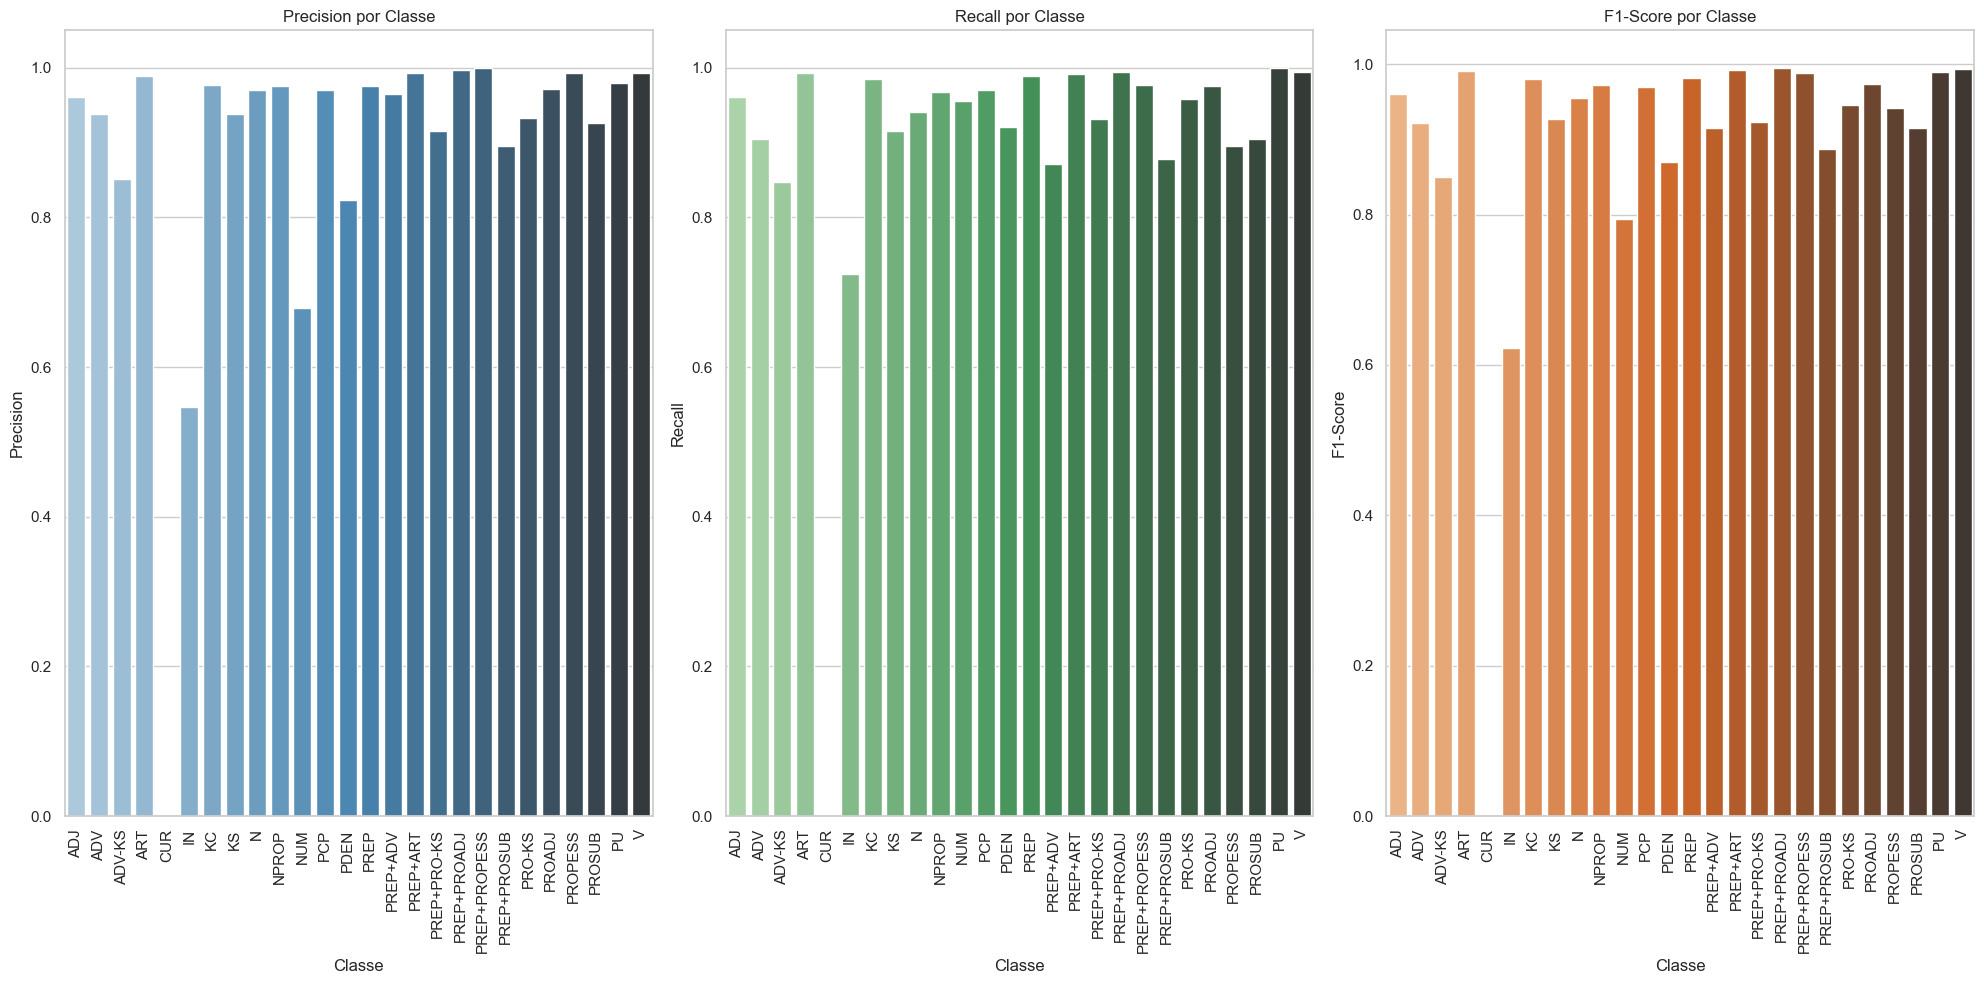

In [13]:
sns.set(style='whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Gráfico Precisão
sns.barplot(x=df_report.index,
            y=df_report['precision'], hue=df_report.index, ax=axes[0], palette='Blues_d')
axes[0].set_title('Precision por Classe')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Precision')
axes[0].tick_params(axis='x', rotation=90)

# Gráfico Recall
sns.barplot(x=df_report.index,
            y=df_report['recall'], hue=df_report.index, ax=axes[1], palette='Greens_d')
axes[1].set_title('Recall por Classe')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Recall')
axes[1].tick_params(axis='x', rotation=90)

# Gráfico F1-Score
sns.barplot(x=df_report.index,
            y=df_report['f1-score'], hue=df_report.index, ax=axes[2], palette='Oranges_d')
axes[2].set_title('F1-Score por Classe')
axes[2].set_xlabel('Classe')
axes[2].set_ylabel('F1-Score')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Aqui vemos que o modelo obteve bons resultados, com todas as classes tendo valores de precisão, recall e F1-Score acima de 0.5. Isso acontece pois as classes mais frequentes e bem representadas no conjunto de dados foram bem assimiladas pelo modelo durante o treinamento. Além disso, o alinhamento adequado entre tokens e tags garantiu uma atribuição precisa das categorias gramaticais. O modelo escolhido já estava finetunado com o corpus Mac-Morpho e isso proporcionou uma base sólida para o reconhecimento das diferentes classes, permitindo que o modelo distinguisse com eficiência as categorias do português. A única tag em que o modelo teve baixo desempenho foi a CUR e isso será analisado posteriormente.

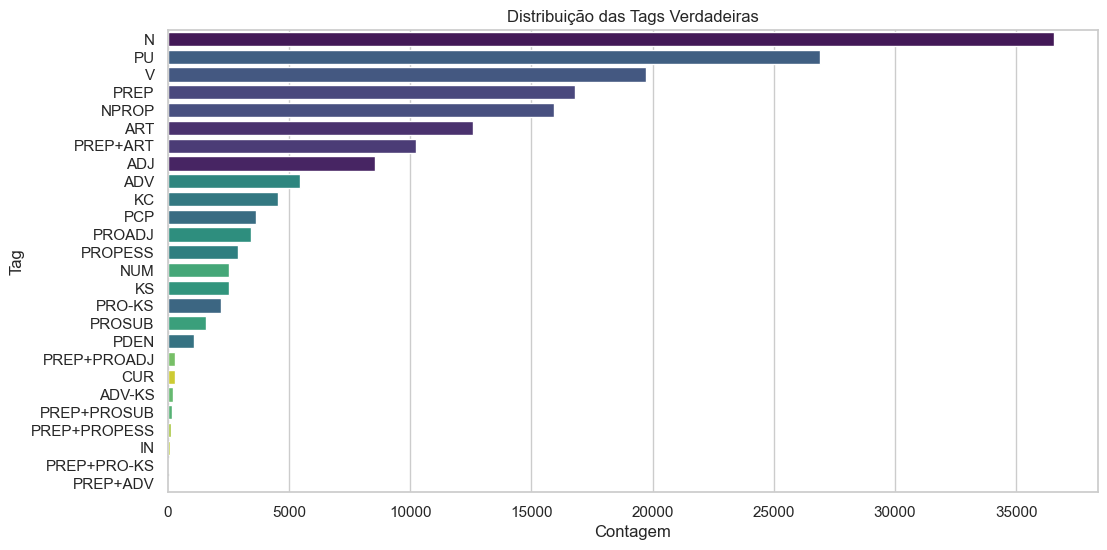

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(y='True Tag', data=df_results,
              order=df_results['True Tag'].value_counts().index, hue='True Tag', legend=False, palette='viridis')
plt.title('Distribuição das Tags Verdadeiras')
plt.xlabel('Contagem')
plt.ylabel('Tag')
plt.show()

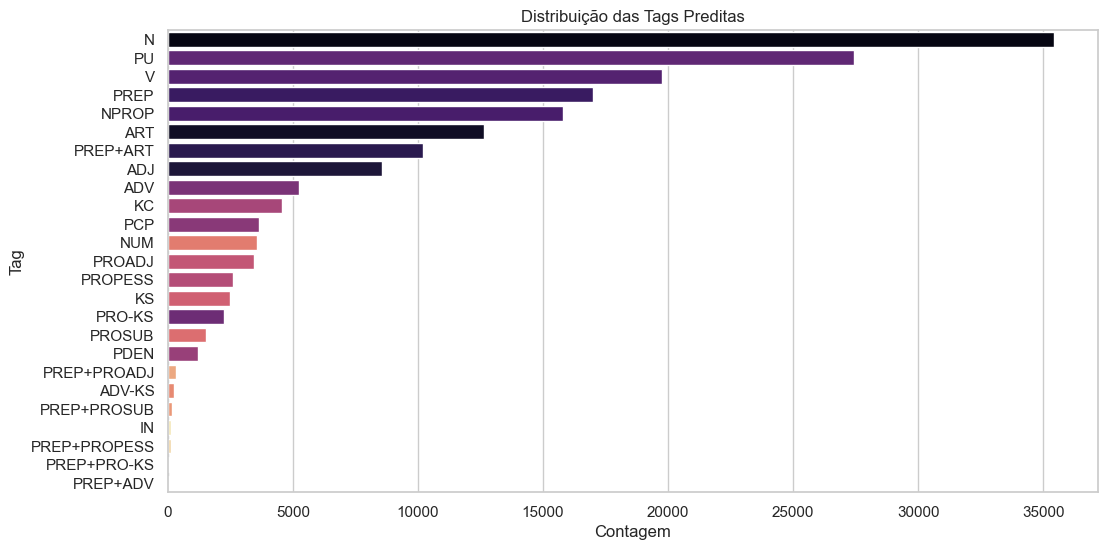

In [18]:
plt.figure(figsize=(12, 6))
sns.countplot(y='Predicted Tag', data=df_results,
              order=df_results['Predicted Tag'].value_counts().index, hue='Predicted Tag', legend=False, palette='magma')
plt.title('Distribuição das Tags Preditas')
plt.xlabel('Contagem')
plt.ylabel('Tag')
plt.show()

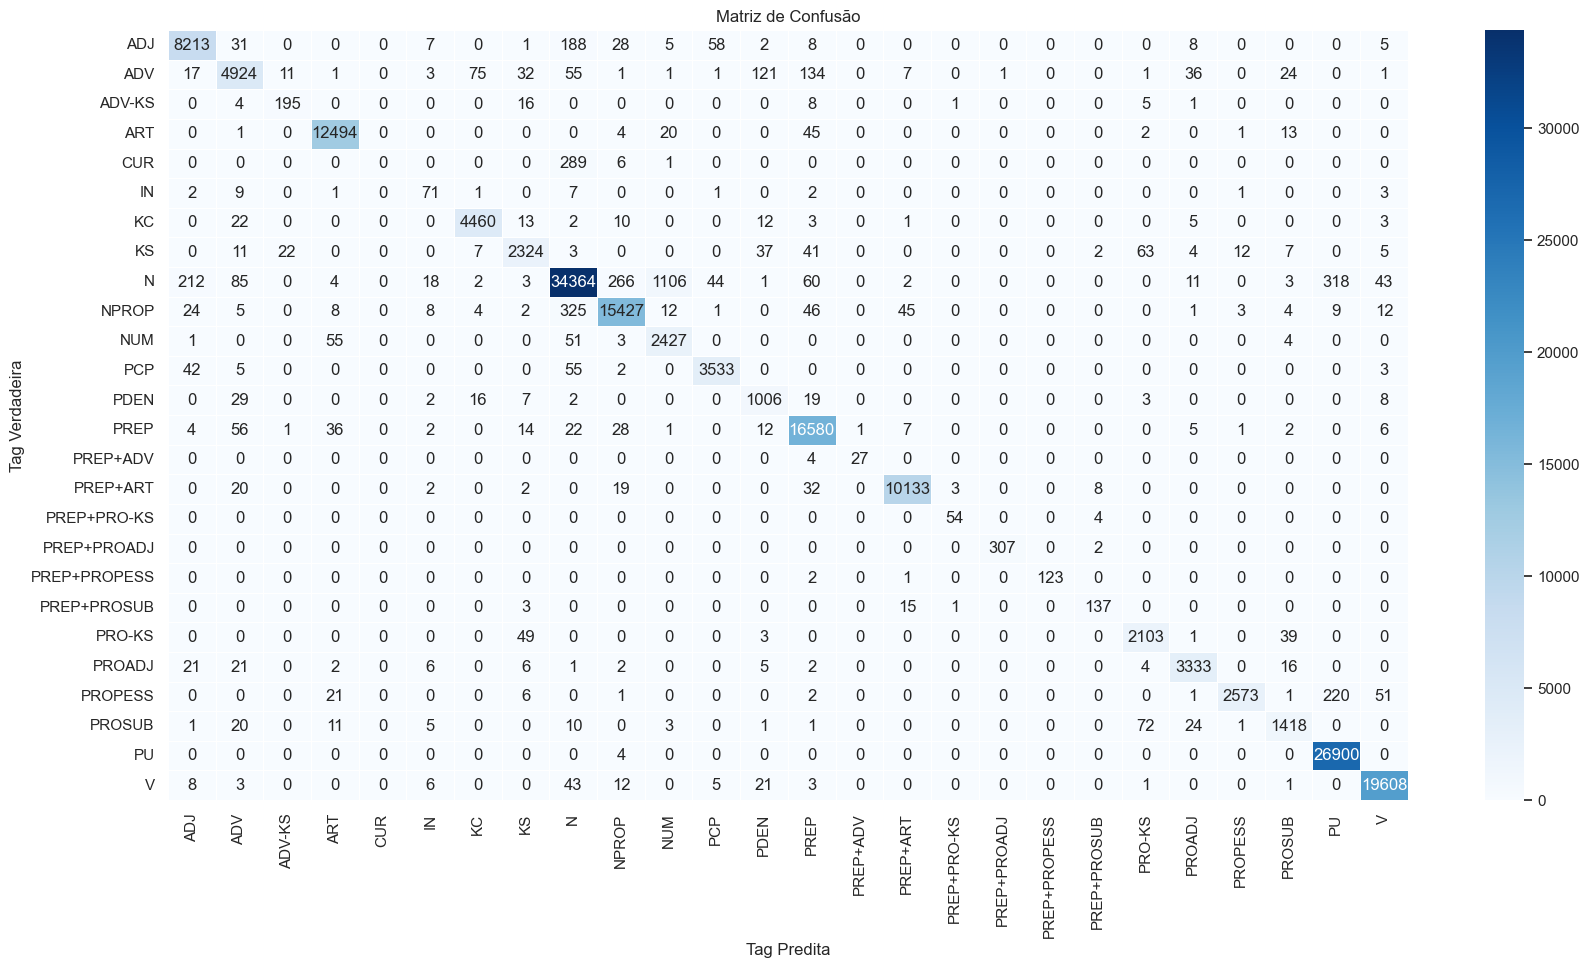

In [14]:
conf_matrix = confusion_matrix(
    df_results['True Tag'], df_results['Predicted Tag'], labels=df_report.index)

df_conf_matrix = pd.DataFrame(
    conf_matrix, index=df_report.index, columns=df_report.index)

plt.figure(figsize=(20, 10))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=.5)
plt.title('Matriz de Confusão')
plt.xlabel('Tag Predita')
plt.ylabel('Tag Verdadeira')
plt.show()

Aqui, observa-se quais tags o modelo mais confundiu, fazedno previsões erradas em algumas delas. Isso pode ser visto nos valores fora da diagonal. Vamos analisar algumas confusões que o modelo teve:

- N (substantivo) confundido com NPROP (Nome Próprio): 266 erros
    - Isso ocorre porque muitos substantivos podem ser usados como nomes próprios dependendo do contexto.
- N confundido com NUM (Numeral): 1106 erros
    - Esse erro pode ocorrer porque um número por extenso pode ser interpretado como um numeral ou como um substantivo.
- ADV (adverbio) confundido com PREP (preposições): 134 erros
    - Esse erro pode ter ocorrido devido à semelhança sintática e funcional de algumas palavras (ex: antes, depois, perto) que podem atuar como adverbios ou preposições dependendo do contexto.

    

In [15]:
df_conf_matrix_errors = df_conf_matrix.copy()
np.fill_diagonal(df_conf_matrix_errors.values, 0)
df_errors = df_conf_matrix_errors.sum(axis=1).sort_values(ascending=False)

print("Classes com Maior Número de Erros:")
display(df_errors)

Classes com Maior Número de Erros:


N               2178
ADV              522
NPROP            509
ADJ              341
PROPESS          303
CUR              296
KS               214
PREP             198
PROSUB           149
NUM              114
PCP              107
V                103
PRO-KS            92
ART               86
PROADJ            86
PREP+ART          86
PDEN              86
KC                71
ADV-KS            35
IN                27
PREP+PROSUB       19
PREP+ADV           4
PU                 4
PREP+PRO-KS        4
PREP+PROPESS       3
PREP+PROADJ        2
dtype: int64

A partir desses resultados, observa-se que a classe N apresenta o maior número de erros. Isso pode ter ocorrido devido à sua alta frequência no conjunto de dados, resultando em um grande número de erros, mesmo que a taxa de erro relativa seja baixa. Por ser uma classe majoritária, o modelo pode tender a cometer mais erros nessa categoria por existirem mais exemplos. Outro motivo é que os substantivos podem ter vários significados dependendo do contexto, levando a confusões.

Outra classe que teve um grande numero de erros foi a ADV. Isso pode ter ocorrido pois advérbios são menos frequentes, dificultadno o aprendizado adequado pelo modelo. Além disso, advérbios podem ser muito confundidos com tags semelhantes como adjetivos, por exemplo.

Outra classe que teve um grande numero de erros foi a NPROP. Isso pode ter ocorrido pois existe uma grande quantidade de nomes próprios, dificultando a generalização do modelo. Outro motivo é que se os nomes próprios podem não estar bem representados no conjunto de treinamento, dificultado o modelo em reconhecê-los.

In [19]:
df_specific = df_results[df_results['True Tag'] == 'CUR']

pred_counts = df_specific['Predicted Tag'].value_counts(
).sort_values(ascending=False)

print(f"Predições para a tag '{'CUR'}':")
display(pred_counts)

Predições para a tag 'CUR':


Predicted Tag
N        289
NPROP      6
NUM        1
Name: count, dtype: int64

In [20]:
def get_error_examples(sentence_idx, df_results, true_tag, pred_tag):
    examples = df_results[(df_results['True Tag'] == true_tag) & (
        df_results['Predicted Tag'] != pred_tag)]
    if examples.empty:
        print(f"Nenhum erro encontrado para a tag '{true_tag}'.")
    else:
        for idx, row in examples.iterrows():
            print(f"Index: {idx}\nPalavra: {row['True Tag']}\nTag Verdadeira: {
                  row['True Tag']}\nTag Predita: {row['Predicted Tag']}\n{'-'*50}")


# Exemplo: Extrair alguns erros para a tag 'CUR'
print(f"Exemplos de Erros para a tag 'CUR':")
errors_cur = df_results[(df_results['True Tag'] == 'CUR') & (
    df_results['Predicted Tag'] != 'CUR')]
display(errors_cur.head(10))

Exemplos de Erros para a tag 'CUR':


,True Tag,Predicted Tag
11779,CUR,N
11800,CUR,N
11888,CUR,N
12111,CUR,N
12199,CUR,N
16751,CUR,N
16771,CUR,N
16813,CUR,N
16844,CUR,N
19690,CUR,N


Por fim, vamos analisar mais à fundo a tag CUR, que teve o pior desempenho do modelo. A partir dos resultados acima, observa-se a maioria das previsões dela foram paga a tag N (substantivo). Isso pode ocorrido por diversos motivos.

Primeiro, CUR provavelmente tem poucos exemplos no conjunto de treinamento, o que dificulta o aprendizado pelo modelo. Além disso, como N é uma classe muito mais frequente, o modelo tende a favorecê-la para reduzir erros, principalmente em casos de desbalanceamento de classes.

Outro fator pode ser a semelhança contextual entre CUR e N, já que ambas podem aparecer em contextos parecidos, tornando a distinção mais difícil. Também pode haver problemas na tokenização, onde as tags não são corretamente alinhadas com os tokens, levando a classificações erradas. A qualidade das anotações no conjunto de dados também pode impactar o desempenho do modelo, caso haja inconsistências na marcação de CUR. 

### Conclusão

Neste trabalho, analisamos o desempenho de um modelo BERT treinado para a tarefa de POS Tagging em português usando o corpus Mac-Morpho. A escolha de um modelo já ajustado foi essencial para garantir bons resultados sem a necessidade de um treinamento complexo e custoso. Isso nos permitiu focar na avaliação da precisão do modelo e na análise das classes gramaticais.

Os resultados mostraram que o modelo teve um bom desempenho na maioria das classes, especialmente em verbos (V), artigos (ART) e pontuação (PU), que foram bem identificados. Também foi eficiente em reconhecer nomes próprios (NPROP), diferenciando-os bem de substantivos comuns.

Por outro lado, algumas classes apresentaram mais desafios. A classe de numerais (NUM) teve muitos acertos, mas também muitas classificações erradas, o que indica que o modelo pode estar generalizando demais. O pior desempenho foi na tag CUR, que quase não foi reconhecida corretamente. Isso pode ter ocorrido por conta do baixo número de exemplos dessa categoria no conjunto de treinamento ou por problemas na forma como as tags foram alinhadas aos tokens.

Os principais erros que observamos foi que substantivos (N) foram muitas vezes confundidos com nomes próprios (NPROP) e numerais (NUM), o que faz sentido, já que algumas palavras podem mudar de significado dependendo do contexto. Adverbios e preposições também foram confundidos, já que algumas palavras podem ter as duas funções dependendo da frase.

Mesmo com esses desafios, o modelo teve um bom desemepenho, com todas as classes alcançando um F1-Score acima de 0.5 (exceto "CUR"). No geral, o trabalho mostrou que modelos baseados em transformers são eficazes para POS Tagging em português, mas ainda há desafios a serem enfrentados, especialmente em categorias menos comuns ou ambíguas.